# baseline NCA
Âæû **E1-1_GNCA** Á∞°ÂåñÊâæÂà∞ÊúÄÂü∫Êú¨ÁöÑNCAÊû∂Êßã

In [56]:
# 1. Ê®ôÊ∫ñÂ∫´
import sys
import os
import io
import json
import glob

# 2. Á¨¨‰∏âÊñπÂ•ó‰ª∂
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. ÂΩ±ÁâáÁõ∏Èóú
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp

# 4. Ë®≠ÂÆö project Ë∑ØÂæëÔºà‰æù‰Ω†Êú¨Ê©üË∑ØÂæëË™øÊï¥Ôºâ
project_root = "C:/Users/GAI/Desktop/ÂëÇÂçöËªí/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython È≠îÊ≥ïÊåá‰ª§ÔºàJupyterÂ∞àÁî®Ôºâ
%reload_ext autoreload
%autoreload 2

# 6. ÂÖ±‰∫´ core_utils ÂáΩÂºèÂ∫´Â∞éÂÖ•
from core_utils.plotting import (
    plt_split_channels,
)

from core_utils.utils_io import (
    np2pil,      # numpy ‚Üí PIL Image
    imwrite,     # ÂÑ≤Â≠òÂúñÂÉèÁÇ∫Ê™îÊ°à
    imencode,    # Á∑®Á¢ºÂúñÂÉèÁÇ∫ byte stream
    im2url,      # ÂúñÂÉèËΩâ base64 URLÔºàHTML È°ØÁ§∫Áî®Ôºâ
    load_emoji   # ËºâÂÖ• emoji ÂúñÂÉè
)

from core_utils.utils_image import (
    imshow,      # Âú® notebook È°ØÁ§∫ÂúñÂÉè
    tile2d,      # Â§öÂúñÊãºÊé•
    zoom         # ÊîæÂ§ßÂúñÂÉè
)

from core_utils.utils_video import (
    save_video,  # ÊâπÊ¨°Ëº∏Âá∫ÂΩ±Áâá
    VideoWriter  # ÈÄêÂπÄÂØ´ÂÖ•ÂΩ±ÁâáÔºàÊîØÊè¥ context managerÔºâ
)

from core_utils.ops_tensor import (
    to_rgb,
    to_rgba,
    to_alpha
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. ÂØ¶È©óÈ†ÖÁõÆ utils ÂáΩÂºèÂ∫´Â∞éÂÖ•
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# Global Params

In [57]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "ü¶é" #@param {type:"string"}


USE_PATTERN_POOL = True


# load data

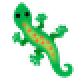

<class 'numpy.ndarray'> (40, 40, 4)


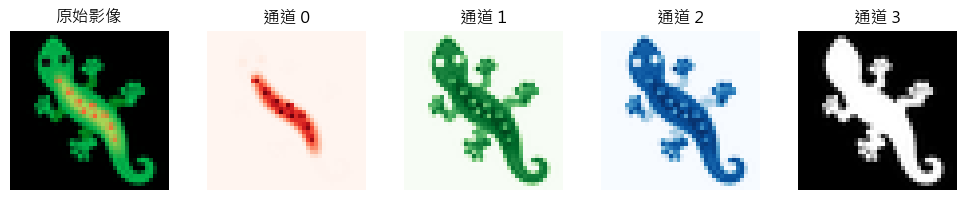

In [58]:
target_img = load_emoji(TARGET_EMOJI, max_size=TARGET_SIZE)
imshow(zoom(to_rgb(target_img), 2), fmt='png')
print(type(target_img), target_img.shape)
plt_split_channels(target_img)


# build Model

## func

In [59]:
def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

## model

In [60]:


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, n_times=1):
    for _ in range(n_times):
      x = self.forward_pass(x)
    return x
  
  @tf.function
  def forward_pass(self, x,angle=0.0):
    y = self.perceive(x, angle)
    dx = self.dmodel(y)
    x += dx 
    return x


CAModel().dmodel.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (1, 3, 3, 128)            6272      
                                                                 
 conv2d_17 (Conv2D)          (1, 3, 3, 16)             2064      
                                                                 
Total params: 8,336
Trainable params: 8,336
Non-trainable params: 0
_________________________________________________________________


# Training

## train setp

## loss_fn

In [61]:
def loss_f(x, target=None):
  return tf.reduce_mean(tf.square(to_rgba(x)-target), [-2, -3, -1])


## init train

In [62]:
# Ë®≠ÂÆöÁõÆÊ®ôÂúñÂÉèÁöÑ paddingÔºåÈÅøÂÖçÈÇäÁïåÊïàÊáâ
p = TARGET_PADDING
target = tf.pad(target_img, [[p, p], [p, p], [0, 0]])

# ÂèñÂæó padding ÂæåÂΩ±ÂÉèÂ∞∫ÂØ∏
height, width = target.shape[:2]

# Âª∫Á´ã NCA ÂàùÂßãÂåñÁöÑÁ®ÆÂ≠êÂºµÈáè seedÔºåshape = (H, W, CHANNEL_N)
seed = np.zeros([height, width, CHANNEL_N], dtype=np.float32)

# Á®ÆÂ≠ê‰∏≠ÂøÉË®≠ÂÆöÁÇ∫Ê¥ªÊÄßÁãÄÊÖãÔºàÈÄöÂ∏∏ÊòØ alpha ÊàñÁâπÂÆöÈÄöÈÅìÂïüÂãïÔºâ
seed[height // 2, width // 2, 3:] = 1.0  # 3: ‰ª£Ë°®ÂæûÁ¨¨ÂõõÂÄãÈÄöÈÅìÈñãÂßã

# Âª∫Á´ã NCA Ê®°ÂûãÂØ¶‰æã
ca = CAModel()

# Ë®≠ÂÆöÂ≠∏ÁøíÁéáËàáÈöéÊ¢ØË°∞Ê∏õÂ≠∏ÁøíÁéáË™øÂ∫¶Âô®
initial_lr = 2e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000], values=[initial_lr, initial_lr * 0.1]
)

# Âª∫Á´ãÂÑ™ÂåñÂô®ÔºåAdam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# ÂàùÂßãÊêçÂ§±Ôºà‰ª•Á®ÆÂ≠êÊé®Ë´ñ‰∏ÄÊ¨°ÊêçÂ§±Ôºâ
loss0 = loss_f(seed, target).numpy()

# Âª∫Á´ã SamplePoolÔºåÂÑ≤Â≠òÂ§öÂÄãÁ®ÆÂ≠ê‰ΩúÁÇ∫Ë®ìÁ∑¥Ê®£Êú¨Ê±†
data={
    'x': np.repeat(seed[None, ...], POOL_SIZE, axis=0)
}
pool = SamplePool(data)


## train step

In [63]:
@tf.function
def train_step(x, target, model, loss_fn, optimizer):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    x = model(x, n_times=iter_n)
    loss = tf.reduce_mean(loss_fn(x, target))
  grads = g.gradient(loss, model.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  optimizer.apply_gradients(zip(grads, model.weights))
  return x, loss

In [64]:
def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

## run train

In [66]:
loss_log=[]

for i in range(100+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0, target).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  print("xo shape", x0.shape)
 
  x, loss = train_step(x0, target, ca, loss_f, optimizer)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%10 == 0:
    viz_pool(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    viz_batch(x0, x, step_i)
    viz_loss(loss_log)
    ca.save('E1_basicGNCA/saved_models/E1_2-baseline_NCA')

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

xo shape (8, 72, 72, 16)


FileNotFoundError: [Errno 2] No such file or directory: 'train_log/0000_pool.jpg'

# Figures

In [ ]:
#@title Training Progress (Checkpoints)

models = []
for i in [100, 500, 1000, 4000]:
  ca = CAModel()
  ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:07<00:00, 62.68it/s]


In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

Moviepy - Building video batches.mp4.
Moviepy - Writing video batches.mp4



Moviepy - Done !
Moviepy - video ready batches.mp4


In [ ]:
#@title Pool Contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

Moviepy - Building video pool.mp4.
Moviepy - Writing video pool.mp4



Moviepy - Done !
Moviepy - video ready pool.mp4


- NCA_repo
    - shared utils
    - E1 basic GNCA (experiment 1)
        - dataSet
        - src
            - gnca-v1.ipyb
            - gnca-v2.ipyb
        - utils
        - logs
        - output_imgs_videos
        - saved_models
    - E2 pinn NCA (experiment 2)
        - dataSet
        - src
            - pinn-nca-v1.ipyb
            - pinn-nca-v2.ipyb
        - utils
        - logs
        - output_imgs_videos
        - saved_models